<center><h1>Sandu_Dhruva_HW5</h1></center>
<br>
<br>

Name: Dhruva Sandu
<br>
Github Username: dhruv0324
<br>
USC ID: 4511600283

## 1. Decision Trees as Interpretable Models

Import packages

In [1]:
!pip install -r ../requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats
from scipy.stats import pearsonr
import seaborn as sns

### (a) Obtain Data

Get the Accute Inamations Data Set

In [3]:
data_path = '../data/diagnosis.data'

columns = ['Temperature', 'Nausea', 'Lumbar_Pain', 'Urine_Pushing', 
           'Micturition_Pains', 'Burning_Urethra', 'Inflammation_Bladder', 
           'Nephritis_Pelvis']

df = pd.read_csv(data_path, sep='\t', header=None, names=columns, encoding='utf-16le')

df['Temperature'] = df['Temperature'].str.replace(',', '.').astype(float)

df['Inflammation_Bladder'] = (df['Inflammation_Bladder'] == 'yes').astype(int)
df['Nephritis_Pelvis'] = (df['Nephritis_Pelvis'] == 'yes').astype(int)

feature_columns = ['Nausea', 'Lumbar_Pain', 'Urine_Pushing', 
                   'Micturition_Pains', 'Burning_Urethra']
for col in feature_columns:
    df[col] = (df[col] == 'yes').astype(int)


In [4]:
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Dataset shape: (120, 8)

First few rows:
   Temperature  Nausea  Lumbar_Pain  Urine_Pushing  Micturition_Pains  \
0         35.5       0            1              0                  0   
1         35.9       0            0              1                  1   
2         35.9       0            1              0                  0   
3         36.0       0            0              1                  1   
4         36.0       0            1              0                  0   

   Burning_Urethra  Inflammation_Bladder  Nephritis_Pelvis  
0                0                     0                 0  
1                1                     1                 0  
2                0                     0                 0  
3                1                     1                 0  
4                0                     0                 0  


In [5]:
print("\nDataset info:")
print(df.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Temperature           120 non-null    float64
 1   Nausea                120 non-null    int64  
 2   Lumbar_Pain           120 non-null    int64  
 3   Urine_Pushing         120 non-null    int64  
 4   Micturition_Pains     120 non-null    int64  
 5   Burning_Urethra       120 non-null    int64  
 6   Inflammation_Bladder  120 non-null    int64  
 7   Nephritis_Pelvis      120 non-null    int64  
dtypes: float64(1), int64(7)
memory usage: 7.6 KB
None


### (b) Build a decision tree

In [6]:
X = df[['Temperature', 'Nausea', 'Lumbar_Pain', 'Urine_Pushing', 
        'Micturition_Pains', 'Burning_Urethra']]
y = df['Nephritis_Pelvis']

clf = DecisionTreeClassifier(criterion='entropy', 
                             random_state=42,
                             max_depth=None)

clf.fit(X, y)

,criterion,'entropy'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


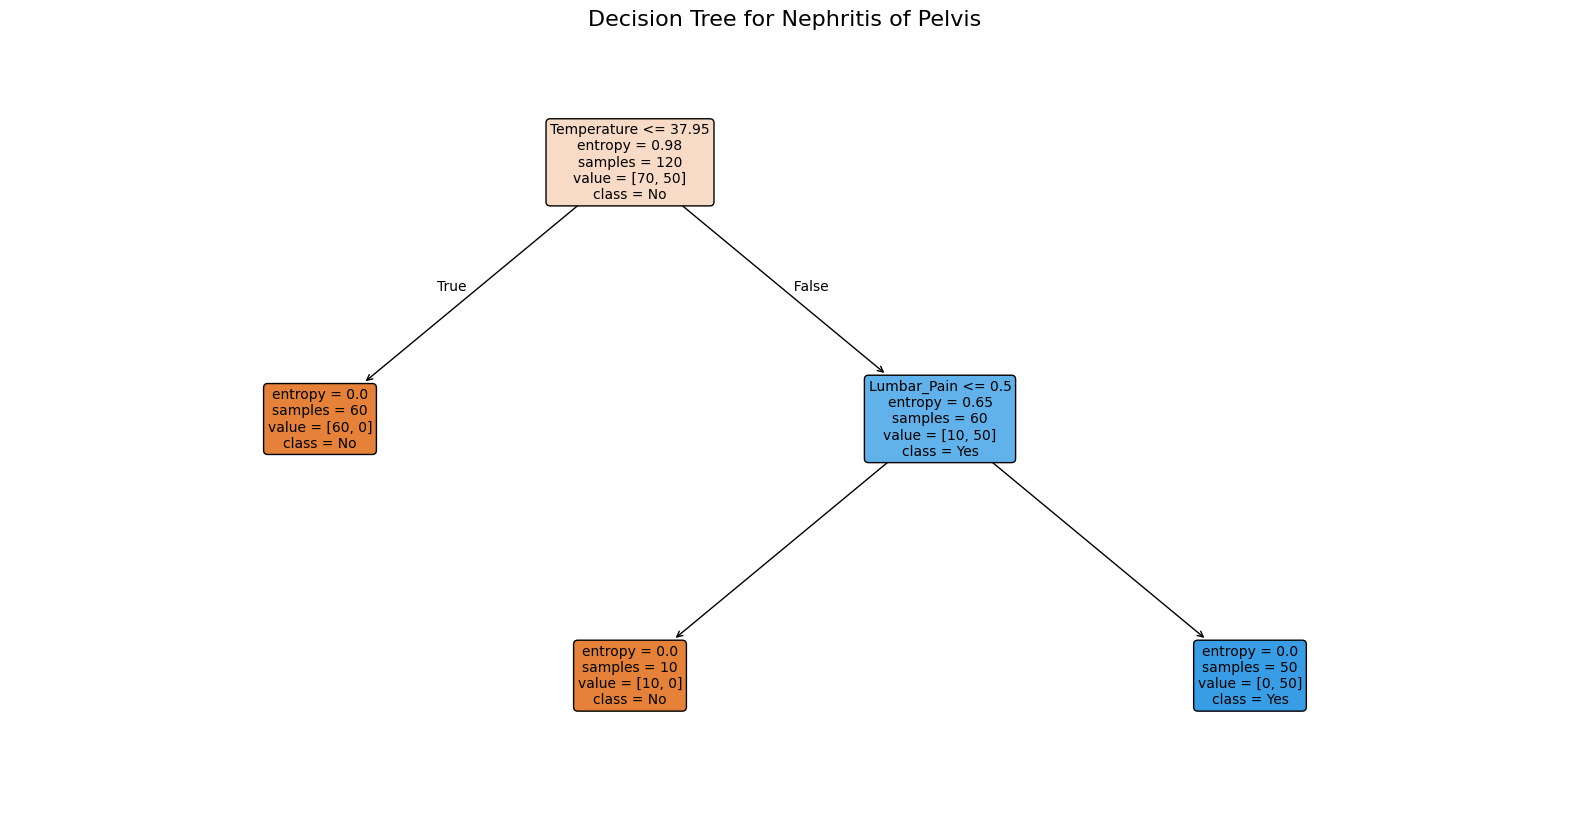

In [7]:
plt.figure(figsize=(20, 10))
feature_names = ['Temperature', 'Nausea', 'Lumbar_Pain', 'Urine_Pushing', 
                 'Micturition_Pains', 'Burning_Urethra']
plot_tree(clf, feature_names=feature_names, 
          class_names=['No', 'Yes'], 
          filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree for Nephritis of Pelvis', fontsize=16)
plt.show()


In [8]:
print(f"Tree depth: {clf.tree_.max_depth}")
print(f"Number of leaves: {clf.tree_.n_leaves}")
print(f"Number of nodes: {clf.tree_.node_count}")

Tree depth: 2
Number of leaves: 3
Number of nodes: 5


### (c) Convert the decision rules

In [9]:
def tree_to_rules(tree, feature_names):
    rules = []
    tree_ = tree.tree_
    
    def dfs(node, depth, parent_path):
        if tree_.feature[node] != -2:  # Not a leaf
            feature_idx = tree_.feature[node]
            threshold = tree_.threshold[node]
            feature_name = feature_names[feature_idx]
            
            # True path (left child)
            dfs(tree_.children_left[node], depth + 1, 
                parent_path + f" AND {feature_name} <= {threshold:.2f}")
            
            # False path (right child)
            dfs(tree_.children_right[node], depth + 1,
                parent_path + f" AND {feature_name} > {threshold:.2f}")
        else:  # Leaf node
            class_idx = np.argmax(tree_.value[node])
            class_label = tree.classes_[class_idx]
            
            value_array = tree_.value[node][0]  
            support = int(value_array[class_idx])  
            total = int(value_array.sum())  
            
            confidence = support / total if total > 0 else 0
            
            rule = parent_path.lstrip(' AND ')
            rules.append({
                'rule': f"IF {rule} THEN class = {class_label}",
                'support': support,
                'total': total,
                'confidence': confidence
            })
    
    dfs(0, 0, "")
    return rules

In [10]:
rules = tree_to_rules(clf, feature_names)

print("Decision Rules:")
print("=" * 80)
for i, rule_dict in enumerate(rules, 1):
    print(f"\nRule {i}:")
    print(rule_dict['rule'])
    print(f"Support: {rule_dict['support']}/{rule_dict['total']} samples")
    print(f"Confidence: {rule_dict['confidence']:.2%}")

Decision Rules:

Rule 1:
IF Temperature <= 37.95 THEN class = 0
Support: 1/1 samples
Confidence: 100.00%

Rule 2:
IF Temperature > 37.95 AND Lumbar_Pain <= 0.50 THEN class = 0
Support: 1/1 samples
Confidence: 100.00%

Rule 3:
IF Temperature > 37.95 AND Lumbar_Pain > 0.50 THEN class = 1
Support: 1/1 samples
Confidence: 100.00%


In [11]:
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas

print(f"Number of alpha values: {len(ccp_alphas)}")
print(f"Alpha range: [{ccp_alphas.min():.6f}, {ccp_alphas.max():.6f}]")
print(f"All alphas: {ccp_alphas}")
ccp_alphas_nonzero = [alpha for alpha in ccp_alphas if alpha > 0]
print(f"\nNon-zero alpha values: {ccp_alphas_nonzero}")


Number of alpha values: 3
Alpha range: [0.000000, 0.654858]
All alphas: [0.         0.32501121 0.65485755]

Non-zero alpha values: [np.float64(0.32501121082417705), np.float64(0.6548575458269756)]


In [12]:
X_train_split, X_val, y_train_split, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

results = []
for alpha in ccp_alphas_nonzero:
    clf_test = DecisionTreeClassifier(criterion='entropy', 
                                      ccp_alpha=alpha, 
                                      random_state=42)
    clf_test.fit(X_train_split, y_train_split)
    
    train_acc = clf_test.score(X_train_split, y_train_split)
    val_acc = clf_test.score(X_val, y_val)
    n_leaves = clf_test.tree_.n_leaves
    depth = clf_test.tree_.max_depth
    
    results.append({
        'alpha': alpha,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'n_leaves': n_leaves,
        'depth': depth
    })
    
    print(f"\nAlpha = {alpha:.8f}:")
    print(f"  Training accuracy: {train_acc:.4f}")
    print(f"  Validation accuracy: {val_acc:.4f}")
    print(f"  Number of leaves: {n_leaves}")
    print(f"  Depth: {depth}")


Alpha = 0.32501121:
  Training accuracy: 1.0000
  Validation accuracy: 1.0000
  Number of leaves: 3
  Depth: 2

Alpha = 0.65485755:
  Training accuracy: 0.5833
  Validation accuracy: 0.5833
  Number of leaves: 1
  Depth: 0


In [13]:
best_result = max(results, key=lambda x: x['val_acc'])
best_alpha = best_result['alpha']

print(f"\n" + "="*80)
print(f"Best alpha: {best_alpha:.8f}")
print(f"Validation accuracy: {best_result['val_acc']:.4f}")
print(f"Number of leaves: {best_result['n_leaves']}")
print(f"Depth: {best_result['depth']}")
print("="*80)



Best alpha: 0.32501121
Validation accuracy: 1.0000
Number of leaves: 3
Depth: 2


In [14]:
clf_pruned = DecisionTreeClassifier(criterion='entropy', 
                                     ccp_alpha=best_alpha, 
                                     random_state=42)
clf_pruned.fit(X, y)

print(f"\nFinal pruned tree (trained on full dataset):")
print(f"Depth: {clf_pruned.tree_.max_depth}")
print(f"Number of leaves: {clf_pruned.tree_.n_leaves}")


Final pruned tree (trained on full dataset):
Depth: 1
Number of leaves: 2


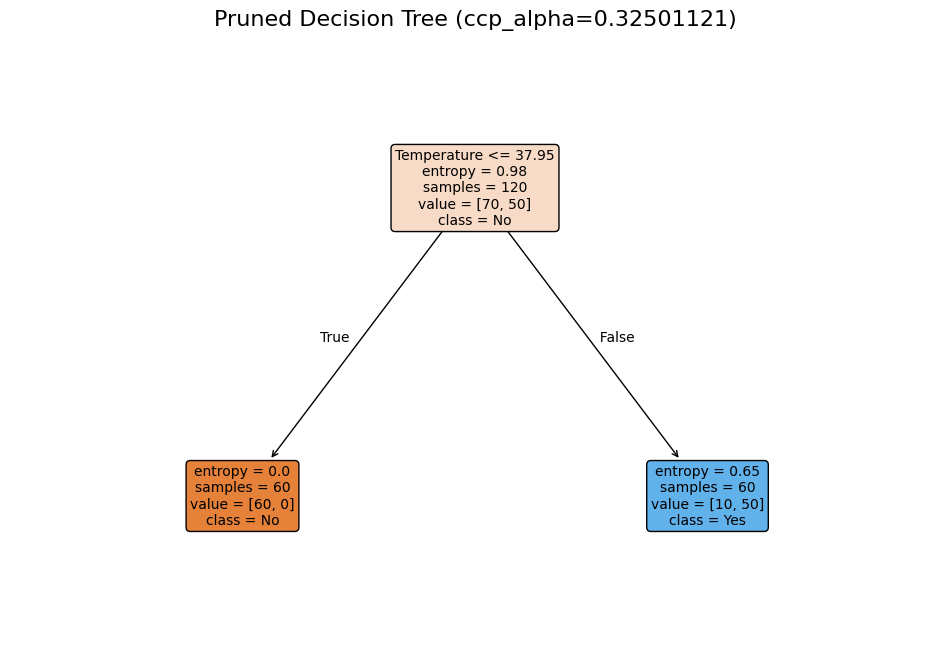

In [15]:
plt.figure(figsize=(12, 8))
plot_tree(clf_pruned, feature_names=feature_names, 
          class_names=['No', 'Yes'], 
          filled=True, rounded=True, fontsize=10)
plt.title(f'Pruned Decision Tree (ccp_alpha={best_alpha:.8f})', fontsize=16)
plt.show()

In [16]:
print("\nPruned Tree Rules:")
print("=" * 80)
pruned_rules = tree_to_rules(clf_pruned, feature_names)
for i, rule_dict in enumerate(pruned_rules, 1):
    print(f"\nRule {i}:")
    print(rule_dict['rule'])
    print(f"Support: {rule_dict['support']}/{rule_dict['total']} samples")
    print(f"Confidence: {rule_dict['confidence']:.2%}")


Pruned Tree Rules:

Rule 1:
IF Temperature <= 37.95 THEN class = 0
Support: 1/1 samples
Confidence: 100.00%

Rule 2:
IF Temperature > 37.95 THEN class = 1
Support: 0/1 samples
Confidence: 0.00%


## 2. The LASSO and Boosting for Regression

### (a) Obtain Data

In [17]:
data_path = '../data/communities.data'

df = pd.read_csv(data_path, header=None, na_values='?')

X = df.iloc[:, :-1]
y = df.iloc[:, -1]

train_size = 1495
X_train = X.iloc[:train_size].copy()
X_test = X.iloc[train_size:].copy()
y_train = y.iloc[:train_size].copy()
y_test = y.iloc[train_size:].copy()

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Number of features: {X_train.shape[1]}")

Training set size: (1495, 127)
Test set size: (499, 127)
Number of features: 127


### (b) Missing values

In [18]:
non_predictive = [0, 1, 2, 3, 4]

X_train_clean = X_train.drop(X_train.columns[non_predictive], axis=1)
X_test_clean = X_test.drop(X_test.columns[non_predictive], axis=1)

print("Missing values in training set:")
missing_counts = X_train_clean.isnull().sum()
print(missing_counts[missing_counts > 0])

Missing values in training set:
30        1
101    1256
102    1256
103    1256
104    1256
105    1256
106    1256
107    1256
108    1256
109    1256
110    1256
111    1256
112    1256
113    1256
114    1256
115    1256
116    1256
117    1256
121    1256
122    1256
123    1256
124    1256
126    1256
dtype: int64


In [19]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(
    imputer.fit_transform(X_train_clean), 
    columns=X_train_clean.columns,
    index=X_train_clean.index
)
X_test_imputed = pd.DataFrame(
    imputer.transform(X_test_clean),
    columns=X_test_clean.columns,
    index=X_test_clean.index
)

print(f"\nFeatures after removing non-predictive: {X_train_imputed.shape[1]}")
print(f"Remaining missing values: {X_train_imputed.isnull().sum().sum()}")


Features after removing non-predictive: 122
Remaining missing values: 0


### (c) Plot a correlation matrix

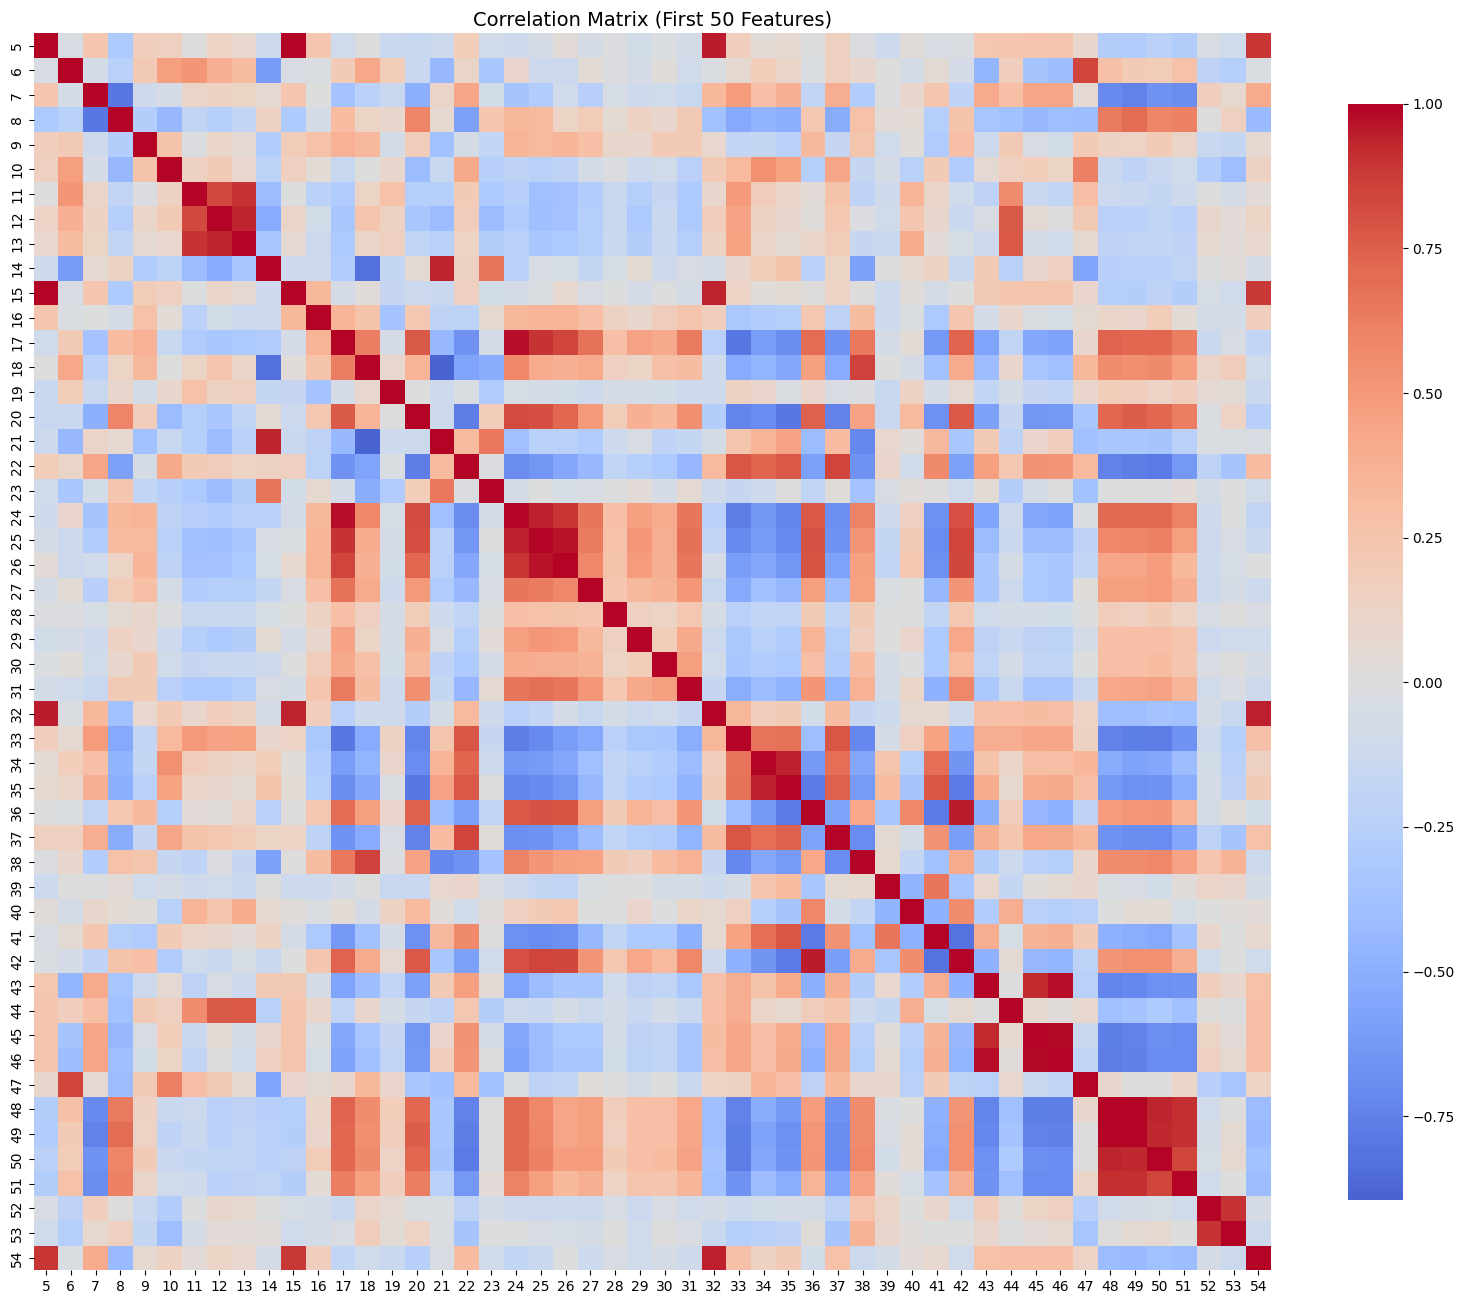

In [20]:
corr_matrix = X_train_imputed.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix.iloc[:50, :50], 
            cmap='coolwarm', 
            center=0, 
            square=True,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix (First 50 Features)', fontsize=14)
plt.tight_layout()
plt.show()



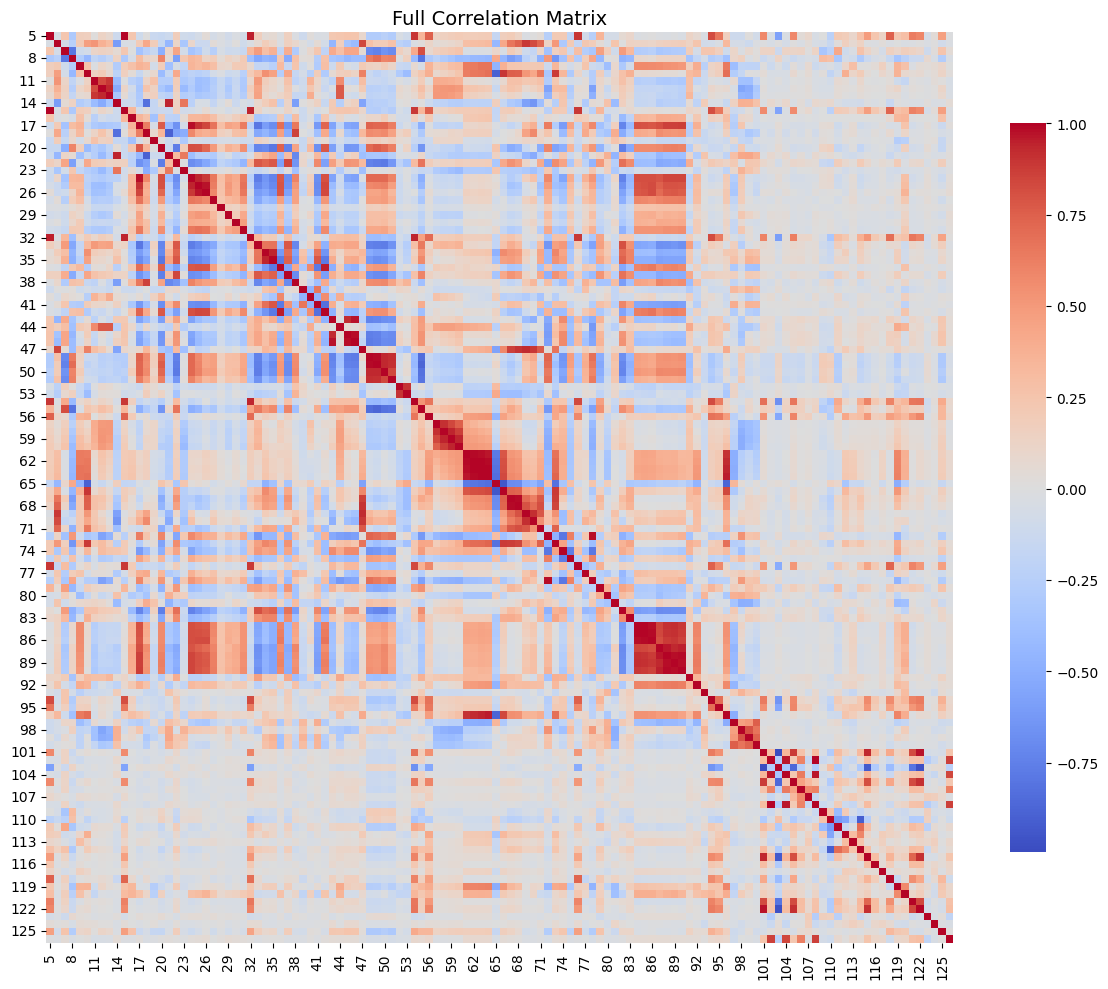

In [21]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, cbar_kws={"shrink": 0.8})
plt.title('Full Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

### (d) Calculate the Coefficient of Variation CV

In [22]:
cv = X_train_imputed.std() / (X_train_imputed.mean() + 1e-10)  # Adding small epsilon to avoid division by zero
cv_sorted = cv.sort_values(ascending=False)

print("Top 20 features by Coefficient of Variation:")
print(cv_sorted.head(20))

Top 20 features by Coefficient of Variation:
95     4.292923
94     3.470952
54     3.058964
56     2.926635
125    2.552946
32     2.342443
5      2.241105
15     2.038461
76     1.968467
118    1.645408
10     1.612091
66     1.456618
7      1.428885
120    1.397110
9      1.359100
61     1.288287
62     1.286184
64     1.270476
63     1.265579
73     1.132926
dtype: float64


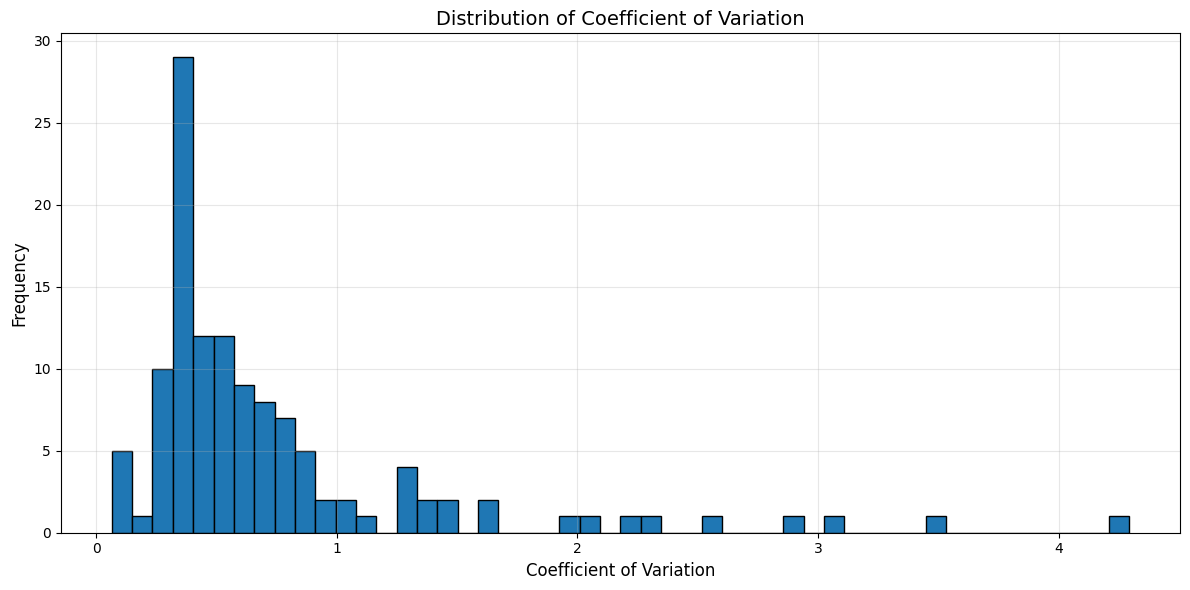

In [23]:
plt.figure(figsize=(12, 6))
plt.hist(cv_sorted, bins=50, edgecolor='black')
plt.xlabel('Coefficient of Variation', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Coefficient of Variation', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [24]:
num_features = int(np.sqrt(128))
high_cv_features = cv_sorted.head(num_features).index.tolist()  
print(f"\nFeatures selected (b√128c = {num_features} features):")
print(high_cv_features)


Features selected (b√128c = 11 features):
[95, 94, 54, 56, 125, 32, 5, 15, 76, 118, 10]


### (e) Scatter plots and box plots for highest CV features

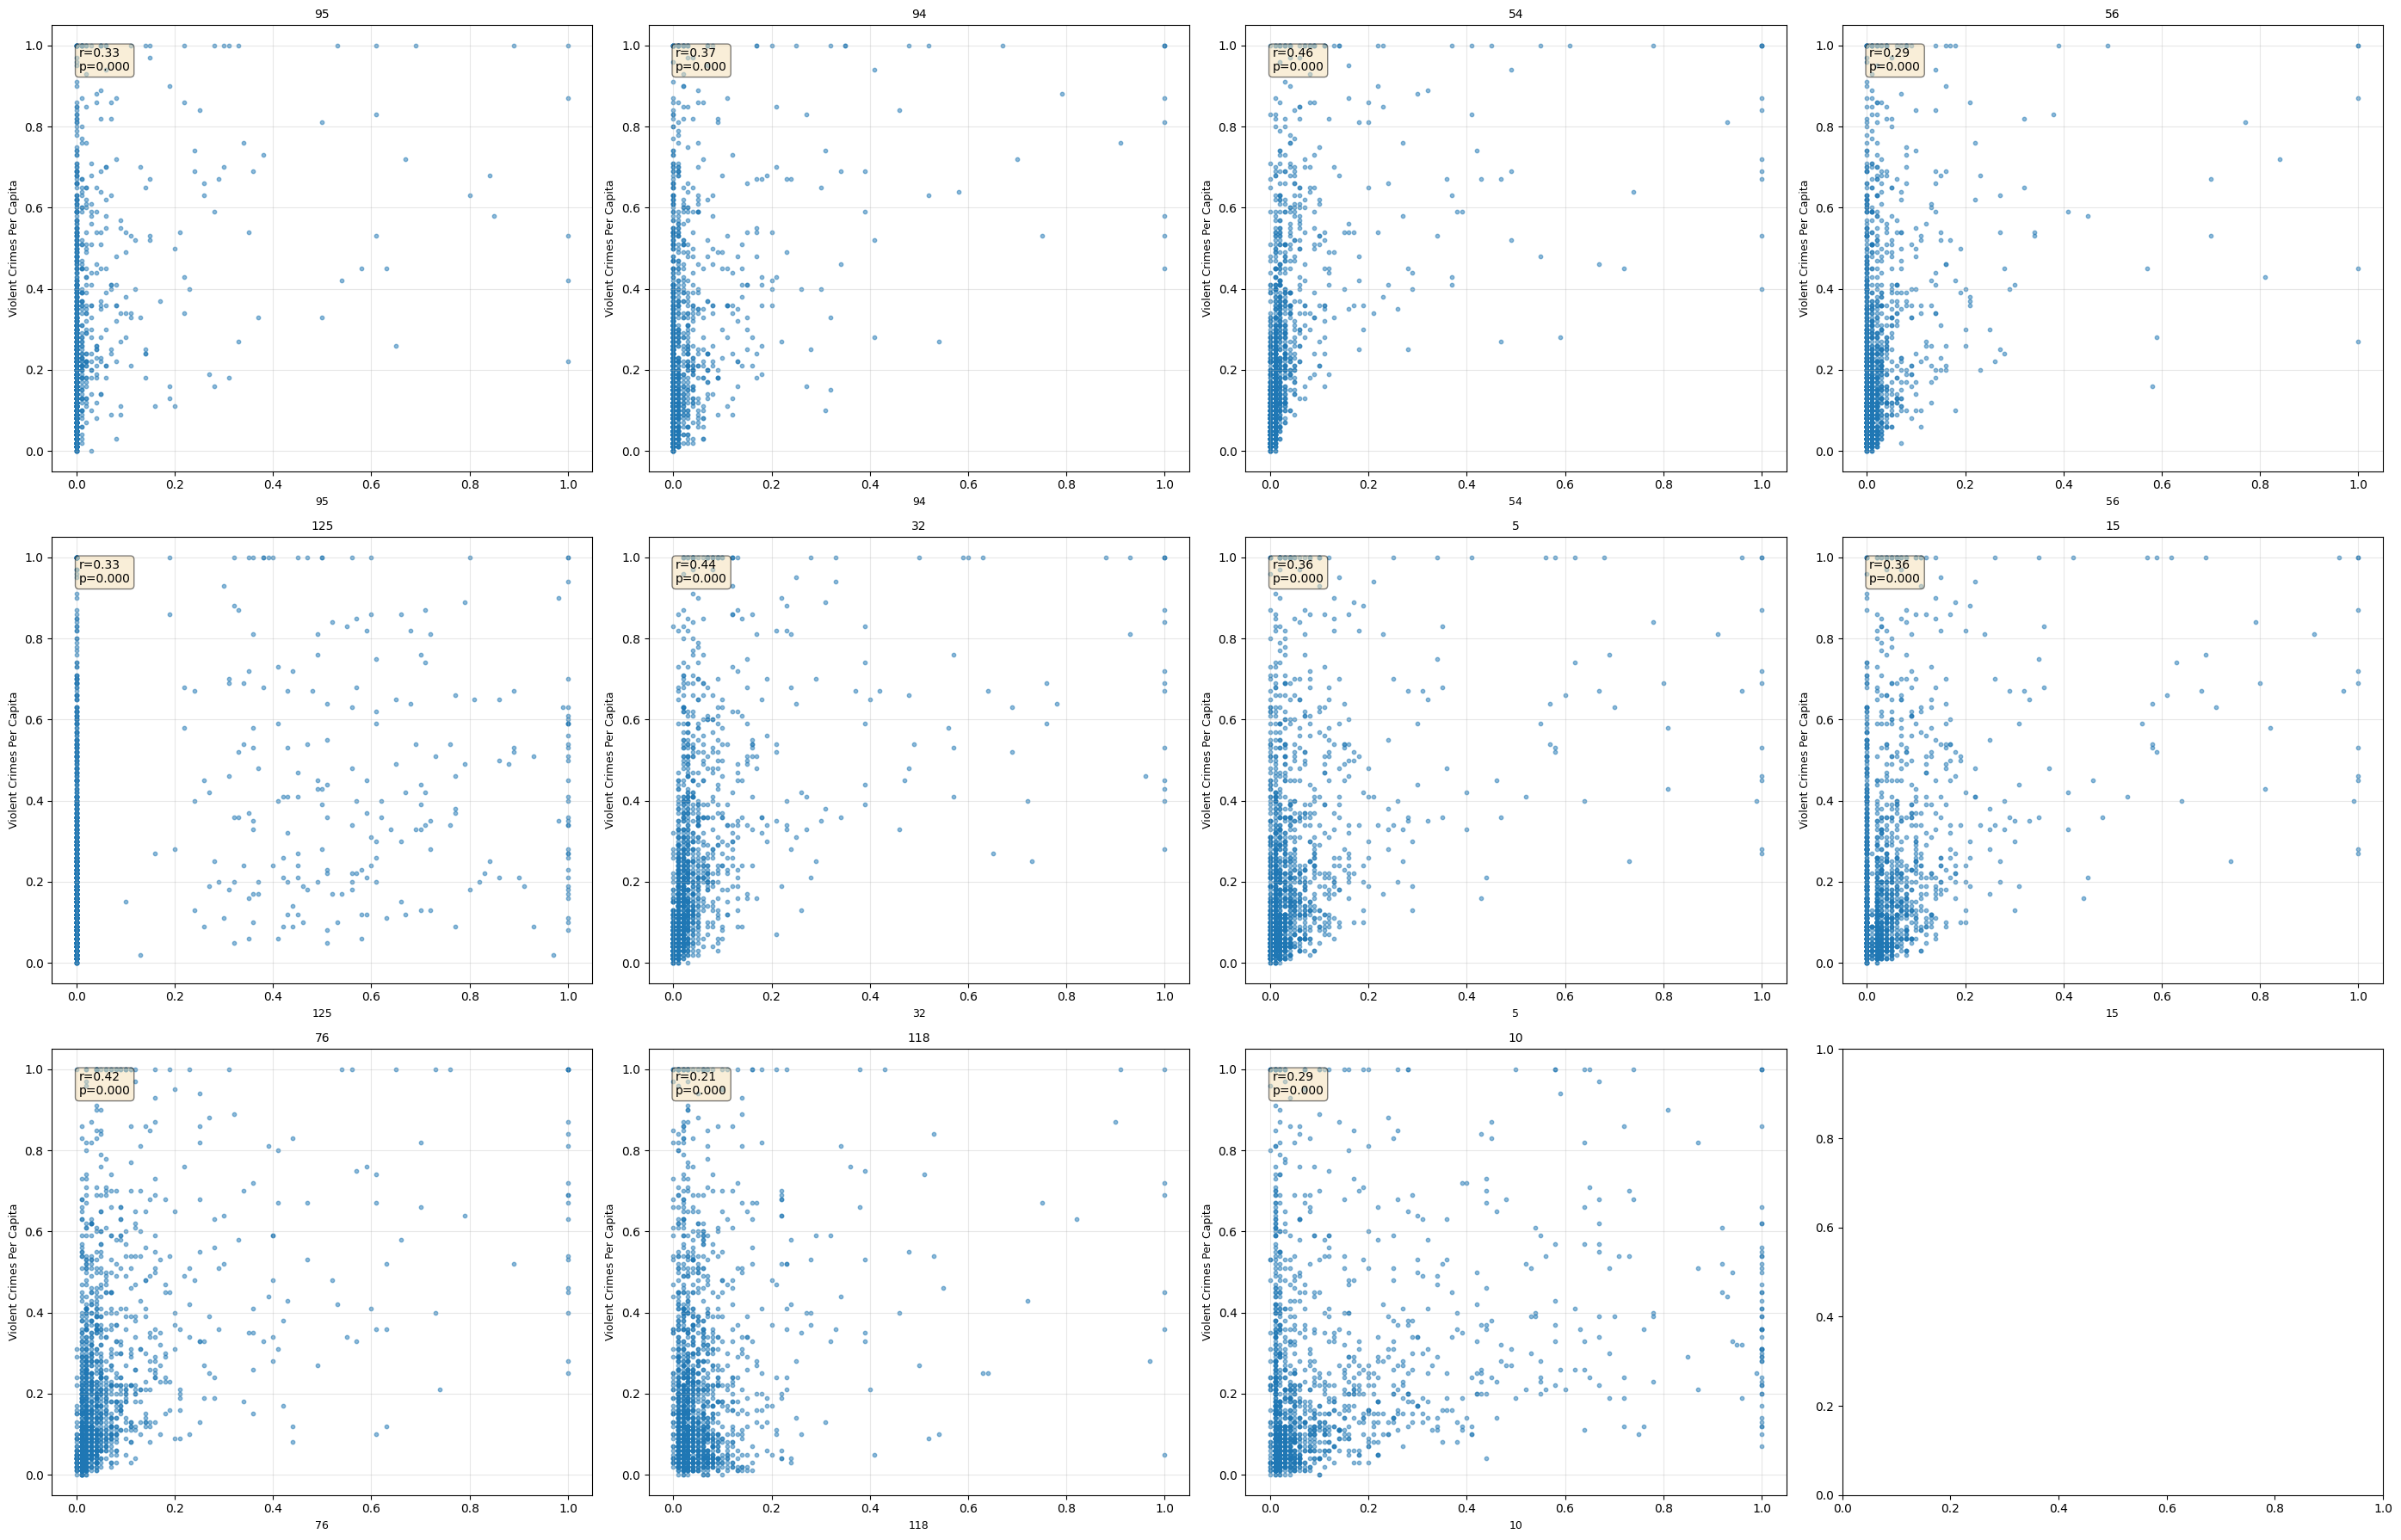

In [25]:
ig, axes = plt.subplots(3, 4, figsize=(28, 18))
axes = axes.flatten()

for i, feature in enumerate(high_cv_features):
    ax = axes[i]
    ax.scatter(X_train_imputed[feature], y_train, alpha=0.5, s=10)
    ax.set_xlabel(feature, fontsize=9)
    ax.set_ylabel('Violent Crimes Per Capita', fontsize=9)
    
    # Handle feature name display
    feature_display = str(feature)[:30] + ('...' if len(str(feature)) > 30 else '')
    ax.set_title(feature_display, fontsize=10)
    
    # Calculate correlation
    corr, p_val = pearsonr(X_train_imputed[feature], y_train)
    ax.text(0.05, 0.95, f'r={corr:.2f}\np={p_val:.3f}', 
            transform=ax.transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

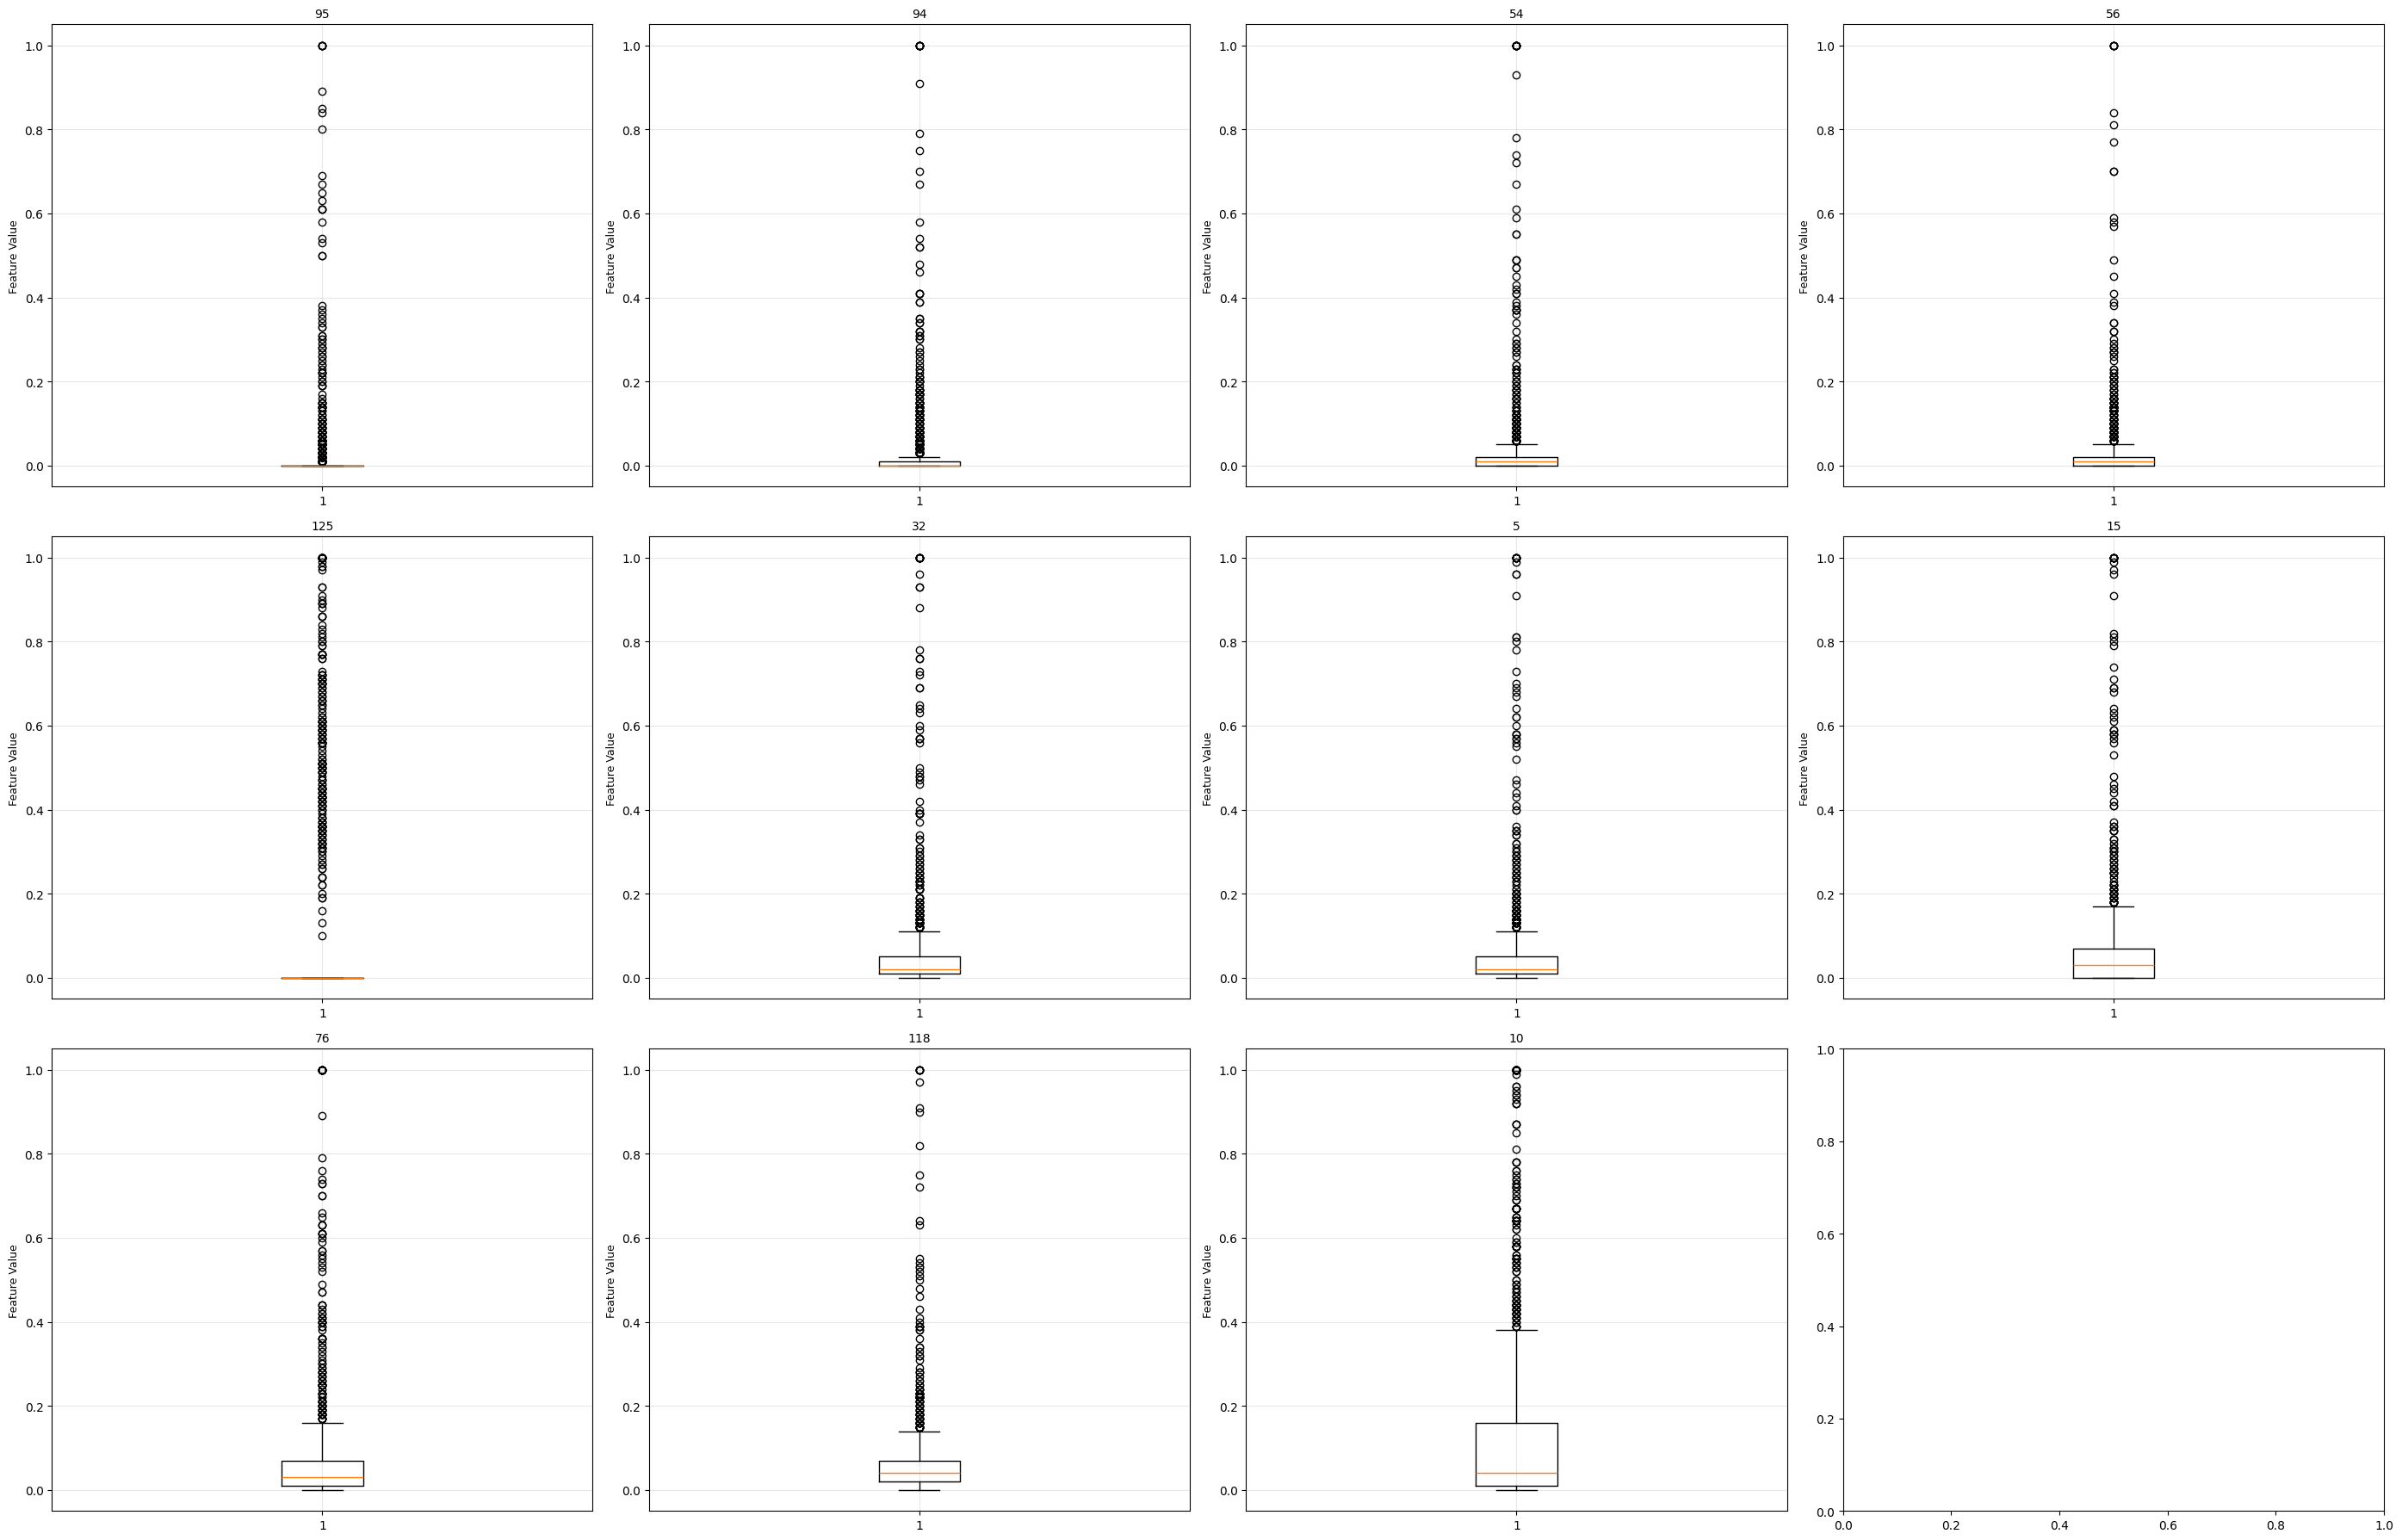

In [26]:
fig, axes = plt.subplots(3, 4, figsize=(28, 18))
axes = axes.flatten()

for i, feature in enumerate(high_cv_features):
    ax = axes[i]
    ax.boxplot(X_train_imputed[feature].dropna())
    ax.set_ylabel('Feature Value', fontsize=9)
    
    feature_display = str(feature)[:30] + ('...' if len(str(feature)) > 30 else '')
    ax.set_title(feature_display, fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### (f) Fit a linear model

In [27]:
lr = LinearRegression()
lr.fit(X_train_imputed, y_train)

y_train_pred = lr.predict(X_train_imputed)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

y_test_pred = lr.predict(X_test_imputed)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Us

In [28]:
print("Linear Regression Results:")
print(f"Training MSE: {train_mse:.4f}")
print(f"Training R2: {train_r2:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R2: {test_r2:.4f}")

Linear Regression Results:
Training MSE: 0.0163
Training R2: 0.7111
Test MSE: 0.0181
Test R2: 0.6185


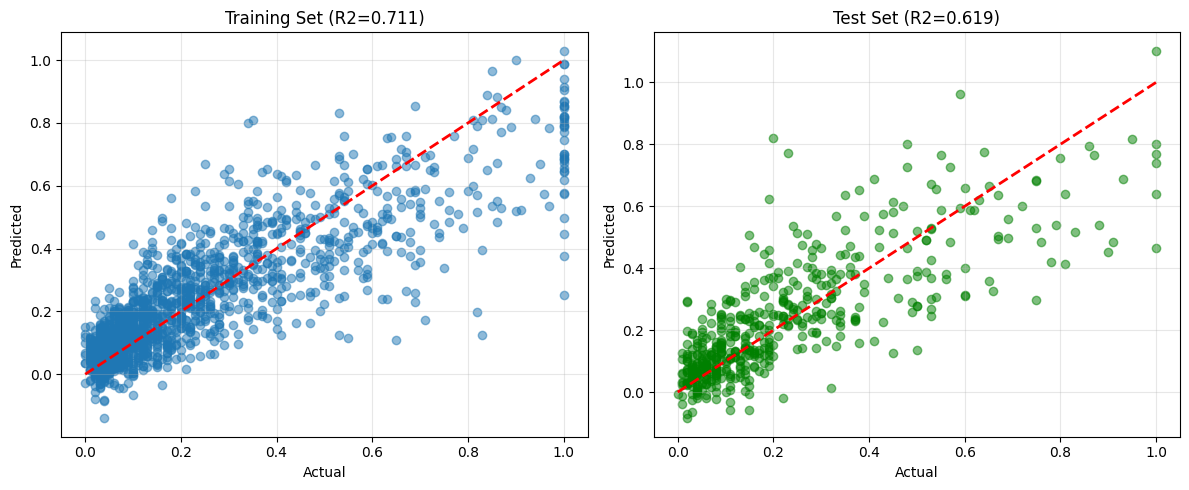

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Training Set (R2={train_r2:.3f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Test Set (R2={test_r2:.3f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### (g) Fit a ridge regression model

In [30]:
alphas = np.logspace(-3, 3, 50)  
ridge = RidgeCV(alphas=alphas, cv=10)
ridge.fit(X_train_imputed, y_train)

/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning

,alphas,array([1.0000...00000000e+03])
,fit_intercept,True
,scoring,None
,cv,10
,gcv_mode,None
,store_cv_results,False
,alpha_per_target,False


In [31]:
print(f"Best alpha (lambda): {ridge.alpha_:.6f}")

Best alpha (lambda): 2.023590


In [32]:
y_train_pred_ridge = ridge.predict(X_train_imputed)
train_mse_ridge = mean_squared_error(y_train, y_train_pred_ridge)
train_r2_ridge = r2_score(y_train, y_train_pred_ridge)

y_test_pred_ridge = ridge.predict(X_test_imputed)
test_mse_ridge = mean_squared_error(y_test, y_test_pred_ridge)
test_r2_ridge = r2_score(y_test, y_test_pred_ridge)

/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Us

In [33]:
print("Ridge Regression Results:")
print(f"Training MSE: {train_mse_ridge:.4f}")
print(f"Training R2: {train_r2_ridge:.4f}")
print(f"Test MSE: {test_mse_ridge:.4f}")
print(f"Test R2: {test_r2_ridge:.4f}")

Ridge Regression Results:
Training MSE: 0.0169
Training R2: 0.7001
Test MSE: 0.0176
Test R2: 0.6295


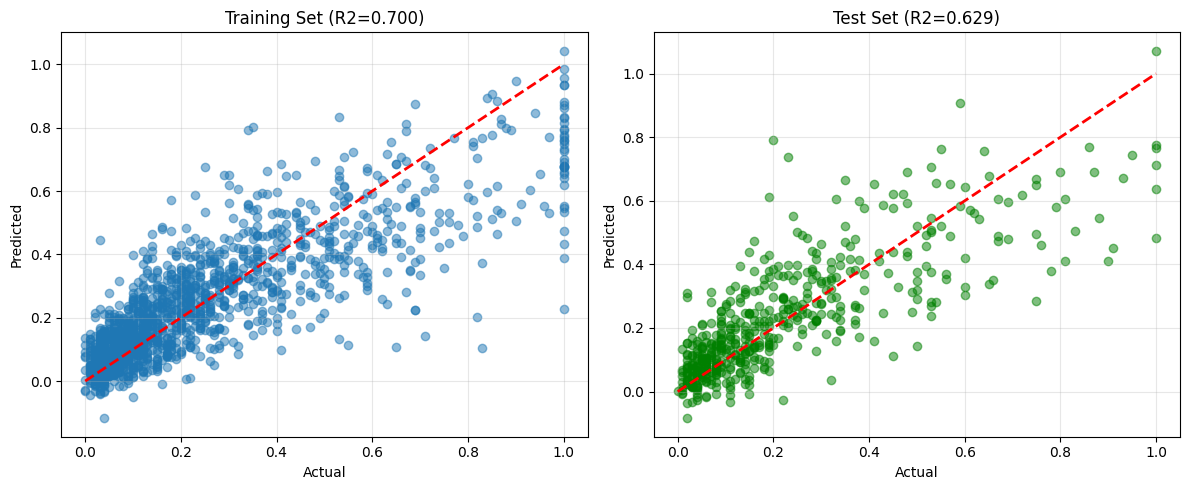

In [34]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_ridge, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Training Set (R2={train_r2_ridge:.3f})')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred_ridge, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Test Set (R2={test_r2_ridge:.3f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### (h) Fit a LASSO model

LASSO without standardization:

In [35]:

alphas = np.logspace(-4, 0, 50)
lasso = LassoCV(alphas=alphas, cv=10, random_state=42, max_iter=2000)
lasso.fit(X_train_imputed, y_train)

,eps,0.001
,n_alphas,'deprecated'
,alphas,array([1.0000...00000000e+00])
,fit_intercept,True
,precompute,'auto'
,max_iter,2000
,tol,0.0001
,copy_X,True
,cv,10
,verbose,False
,n_jobs,None


In [36]:
print(f"Best alpha (lambda): {lasso.alpha_:.6f}")
print(f"Number of features selected: {np.sum(lasso.coef_ != 0)}")

Best alpha (lambda): 0.000121
Number of features selected: 76


In [37]:
y_test_pred_lasso = lasso.predict(X_test_imputed)
test_mse_lasso = mean_squared_error(y_test, y_test_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [38]:
selected_features = X_train_imputed.columns[lasso.coef_ != 0]
print("\nVariables selected by LASSO (without standardization):")
print(f"Number: {len(selected_features)}")
for feat in selected_features:
    print(f"  - {feat}")


Variables selected by LASSO (without standardization):
Number: 76
  - 7
  - 9
  - 11
  - 12
  - 16
  - 18
  - 19
  - 20
  - 21
  - 22
  - 23
  - 26
  - 27
  - 28
  - 29
  - 30
  - 31
  - 33
  - 34
  - 38
  - 39
  - 41
  - 43
  - 44
  - 45
  - 49
  - 50
  - 51
  - 53
  - 54
  - 55
  - 56
  - 57
  - 60
  - 64
  - 66
  - 68
  - 69
  - 72
  - 73
  - 74
  - 75
  - 76
  - 77
  - 79
  - 80
  - 81
  - 82
  - 83
  - 84
  - 87
  - 90
  - 91
  - 92
  - 93
  - 94
  - 95
  - 96
  - 97
  - 99
  - 104
  - 105
  - 107
  - 109
  - 111
  - 113
  - 115
  - 116
  - 117
  - 118
  - 119
  - 120
  - 123
  - 124
  - 125
  - 126


In [39]:
print("\nLASSO without standardization:")
print(f"Test MSE: {test_mse_lasso:.4f}")
print(f"Test R2: {test_r2_lasso:.4f}")


LASSO without standardization:
Test MSE: 0.0177
Test R2: 0.6268


Lasso with standardisation:

In [40]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

lasso_scaled = LassoCV(alphas=alphas, cv=10, random_state=42, max_iter=2000)
lasso_scaled.fit(X_train_scaled, y_train)

,eps,0.001
,n_alphas,'deprecated'
,alphas,array([1.0000...00000000e+00])
,fit_intercept,True
,precompute,'auto'
,max_iter,2000
,tol,0.0001
,copy_X,True
,cv,10
,verbose,False
,n_jobs,None


In [41]:
print(f"\nBest alpha (lambda) with standardization: {lasso_scaled.alpha_:.6f}")
print(f"Number of features selected (with standardization): {np.sum(lasso_scaled.coef_ != 0)}")


Best alpha (lambda) with standardization: 0.000655
Number of features selected (with standardization): 76


In [42]:
y_test_pred_lasso_scaled = lasso_scaled.predict(X_test_scaled)
test_mse_lasso_scaled = mean_squared_error(y_test, y_test_pred_lasso_scaled)
test_r2_lasso_scaled = r2_score(y_test, y_test_pred_lasso_scaled)


/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [43]:
selected_features_scaled = X_train_imputed.columns[lasso_scaled.coef_ != 0]
print("\nVariables selected by LASSO (with standardization):")
print(f"Number: {len(selected_features_scaled)}")
for feat in selected_features_scaled:
    print(f"  - {feat}")


Variables selected by LASSO (with standardization):
Number: 76
  - 5
  - 7
  - 9
  - 11
  - 12
  - 16
  - 18
  - 19
  - 20
  - 21
  - 22
  - 23
  - 26
  - 27
  - 28
  - 29
  - 30
  - 31
  - 33
  - 34
  - 38
  - 39
  - 41
  - 43
  - 44
  - 45
  - 49
  - 50
  - 51
  - 53
  - 54
  - 55
  - 56
  - 60
  - 64
  - 66
  - 68
  - 69
  - 72
  - 73
  - 74
  - 75
  - 76
  - 77
  - 79
  - 80
  - 81
  - 82
  - 83
  - 84
  - 87
  - 90
  - 91
  - 92
  - 93
  - 94
  - 95
  - 96
  - 99
  - 104
  - 105
  - 107
  - 109
  - 110
  - 111
  - 112
  - 113
  - 115
  - 116
  - 117
  - 118
  - 119
  - 120
  - 121
  - 123
  - 124


In [44]:
print("\nLASSO with standardization:")
print(f"Test MSE: {test_mse_lasso_scaled:.4f}")
print(f"Test R2: {test_r2_lasso_scaled:.4f}")


LASSO with standardization:
Test MSE: 0.0178
Test R2: 0.6248


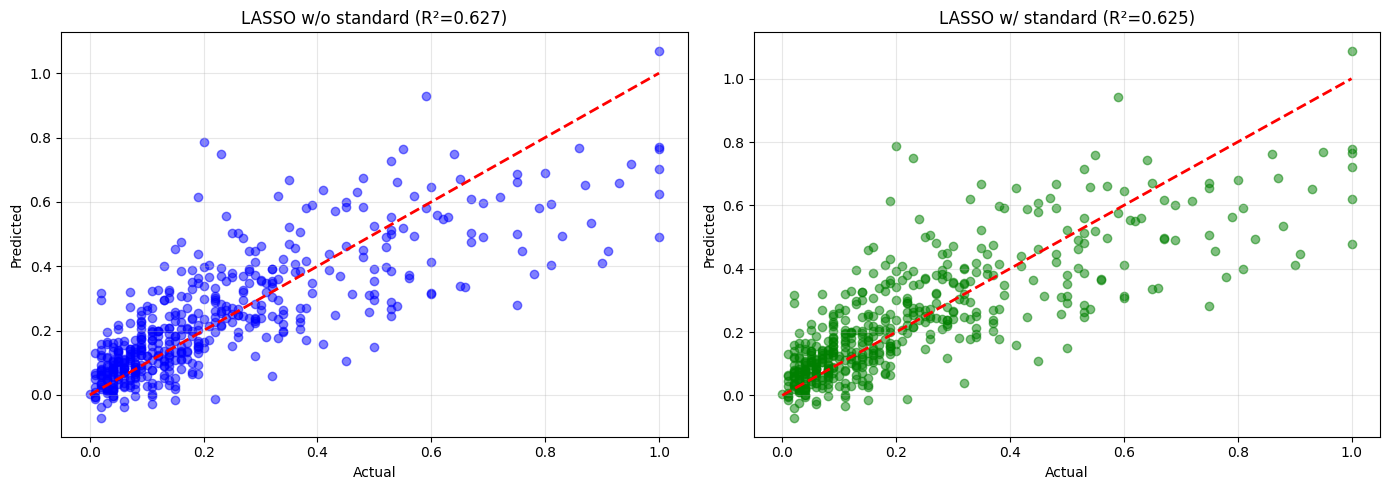

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_test, y_test_pred_lasso, alpha=0.5, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'LASSO w/o standard (R²={test_r2_lasso:.3f})')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_test, y_test_pred_lasso_scaled, alpha=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'LASSO w/ standard (R²={test_r2_lasso_scaled:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### (i) Fit a PCR model

In [46]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_imputed)
X_test_pca = pca.transform(X_test_imputed)

/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/decomposition/_pca.py:604: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/

In [47]:
n_components_range = range(1, min(50, X_train_imputed.shape[1]), 2)
cv_scores = []
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
for n_comp in n_components_range:
    lr_pca = LinearRegression()
    scores = cross_val_score(lr_pca, X_train_pca[:, :n_comp], y_train, 
                             cv=kfold, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())

/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Us

In [48]:
best_M = n_components_range[np.argmin(cv_scores)]
print(f"Best M (number of components): {best_M}")

Best M (number of components): 45


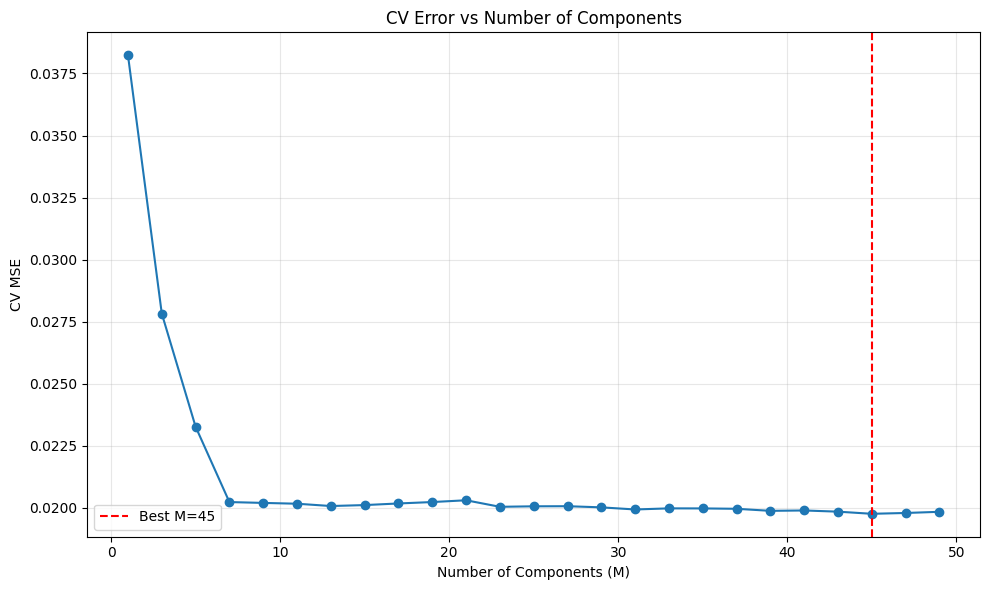

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, cv_scores, marker='o')
plt.axvline(best_M, color='r', linestyle='--', label=f'Best M={best_M}')
plt.xlabel('Number of Components (M)')
plt.ylabel('CV MSE')
plt.title('CV Error vs Number of Components')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [50]:
lr_best = LinearRegression()
lr_best.fit(X_train_pca[:, :best_M], y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [51]:
y_test_pred_pcr = lr_best.predict(X_test_pca[:, :best_M])
test_mse_pcr = mean_squared_error(y_test, y_test_pred_pcr)
test_r2_pcr = r2_score(y_test, y_test_pred_pcr)

/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/dhruvsandu/Library/Mobile Documents/com~apple~CloudDocs/USC/552-Machine Learning/hw5/venv/lib/python3.10/site-packages/sklearn/linear_model/_base.py:280: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


In [52]:
print("\nPCR Results:")
print(f"Best M: {best_M}")
print(f"Test MSE: {test_mse_pcr:.4f}")
print(f"Test R2: {test_r2_pcr:.4f}")


PCR Results:
Best M: 45
Test MSE: 0.0183
Test R2: 0.6149


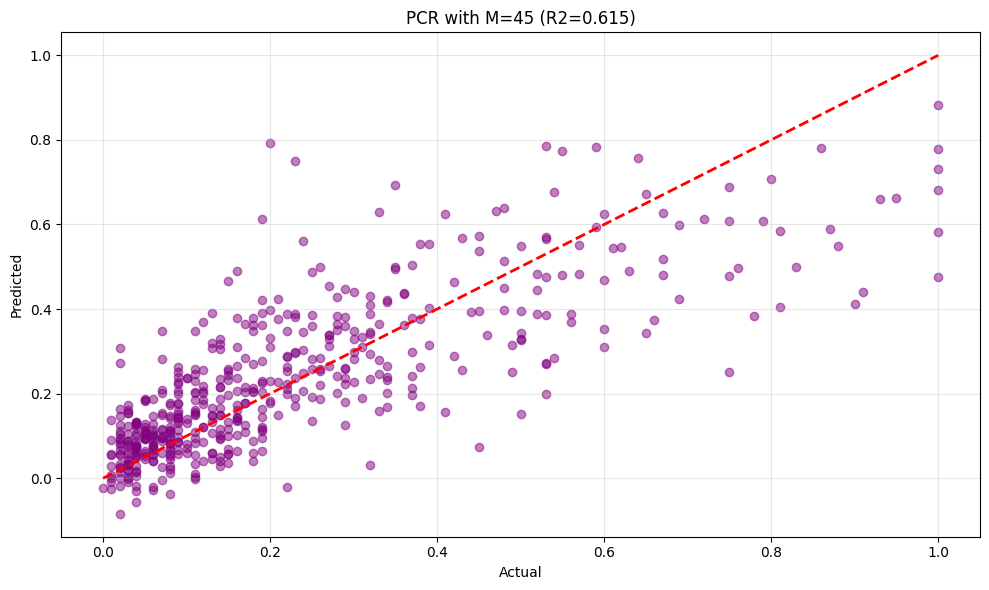

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred_pcr, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'PCR with M={best_M} (R2={test_r2_pcr:.3f})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### (j) Fit a boosting tree

Note: Using sklearn's GradientBoostingRegressor due to XGBoost compatibility issues with 
my Python environment.

In [54]:
param_grid = {
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [100, 150],
        'max_depth': [4, 6],
        'subsample': [0.8],
        'alpha': [0.5, 0.9]  
    }

gb_model = GradientBoostingRegressor(loss='squared_error', random_state=42)
grid = GridSearchCV(gb_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train_imputed, y_train)

print(f"Best parameters: {grid.best_params_}")


Best parameters: {'alpha': 0.5, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 150, 'subsample': 0.8}


In [55]:
final_model = grid.best_estimator_
y_test_pred = final_model.predict(X_test_imputed)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [56]:
print("\nResults:")
print(f"Test MSE: {test_mse:.4f}")
print(f"Test R2: {test_r2:.4f}")


Results:
Test MSE: 0.0167
Test R2: 0.6490


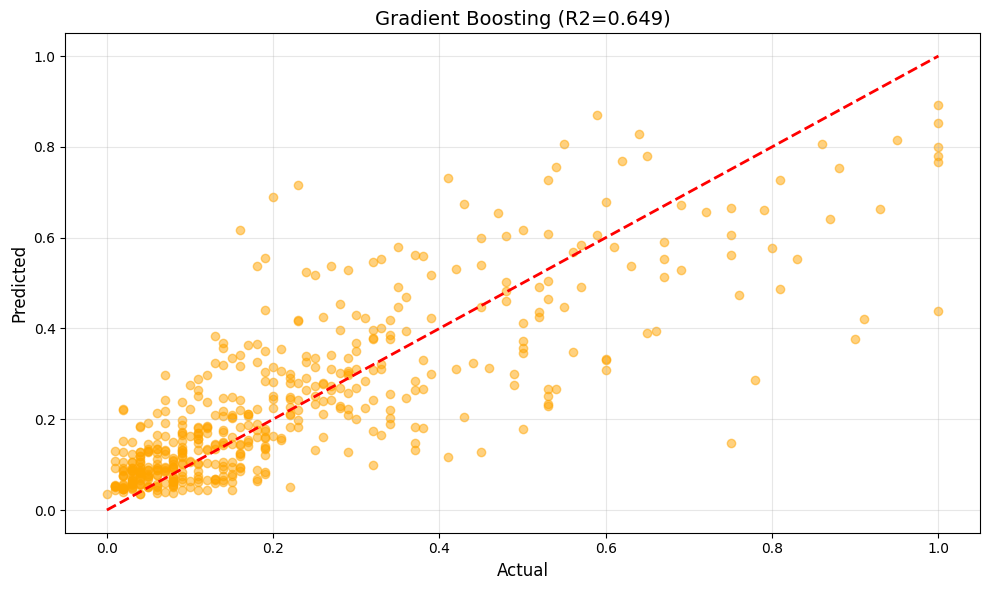

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual', fontsize=12)
plt.ylabel('Predicted', fontsize=12)
plt.title(f'Gradient Boosting (R2={test_r2:.3f})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [58]:
importance_dict = dict(zip(X_train_imputed.columns, final_model.feature_importances_))
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Most Important Features:")
for feat, imp in sorted_importance:
    print(f"  {feat}: {imp:.4f}")


Top 10 Most Important Features:
  55: 0.2713
  49: 0.2332
  8: 0.0369
  7: 0.0290
  76: 0.0204
  54: 0.0198
  73: 0.0193
  48: 0.0158
  95: 0.0140
  74: 0.0127
